In [43]:
# Step 0. Load libraries and custom modules
# Basic input/output
import pickle
# Matrices and dataframes
import numpy as np
import pandas as pd
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# Maths and Stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox
# Data pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import (ColumnTransformer, make_column_selector)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# Metrics
from sklearn.metrics import r2_score, mean_squared_error
# Display pipelines
from sklearn import set_config
set_config(display='diagram')

In [3]:
# Step 1. Load data and prepare

#    (a) Original owners of database:
# 	Marine Resources Division
# 	Marine Research Laboratories - Taroona
# 	Department of Primary Industry and Fisheries, Tasmania
# 	GPO Box 619F, Hobart, Tasmania 7001, Australia
# 	(contact: Warwick Nash +61 02 277277, wnash@dpi.tas.gov.au)

#    (b) Donor of database:
# 	Sam Waugh (Sam.Waugh@cs.utas.edu.au)
# 	Department of Computer Science, University of Tasmania
# 	GPO Box 252C, Hobart, Tasmania 7001, Australia

#    (c) Date received: December 1995

# Relevant Information Paragraph:

#    Predicting the age of abalone from physical measurements.  
#    The age of abalone is determined by cutting the shell through the 
#    cone, staining it, and counting the number of rings through a 
#    microscope -- a boring and time-consuming task.  Other 
#    measurements, which are easier to obtain, are used to predict the 
#    age.  Further information, such as weather patterns and location 
#    (hence food availability) may be required to solve the problem.

#    From the original data examples with missing values were removed 
#    (the majority having the predicted value missing), and the ranges 
#    of the continuous values have been scaled for use with an ANN 
#    (by dividing by 200).

#    Data comes from an original (non-machine-learning) study:

# 	Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn 
#   and Wes B Ford (1994) "The Population Biology of Abalone 
#   (_Haliotis_species) in Tasmania. I. Blacklip Abalone (_H. rubra_) 
#   from the North Coast and Islands of Bass Strait", Sea Fisheries 
#   Division, Technical Report No. 48 (ISSN 1034-3288)

#  Attribute information:

#    Given is the attribute name, attribute type, the measurement unit 
#    and a brief description.  The number of rings is the value to 
#    predict: either as a continuous value or as a classification 
#    problem.

# 	Name		    Data Type	Meas.	Description
# 	----		    ---------	-----	-----------
# 	Sex		        nominal			    M, F, and I (infant)
# 	Length		    continuous	mm	    Longest shell measurement
# 	Diameter	    continuous	mm	    perpendicular to length
# 	Height		    continuous	mm	    with meat in shell
# 	Whole weight	continuous	grams	whole abalone
# 	Shucked weight	continuous	grams	weight of meat
# 	Viscera weight	continuous	grams	gut weight (after bleeding)
# 	Shell weight	continuous	grams	after being dried
# 	Rings		    integer			    +1.5 gives the age in years

url = 'https://archive.ics.uci.edu/ml/' + \
    'machine-learning-databases/abalone/abalone.data'
df_raw = pd.read_csv(url, header=None)
df_raw.columns = ['sex','length_mm','diameter_mm','height_mm',
    'whole_weight_gr','shucked_weight_gr','viscera_weight_gr',
    'shell_weight_gr','rings']

In [4]:
# 1.1 Get basic info
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                4177 non-null   object 
 1   length_mm          4177 non-null   float64
 2   diameter_mm        4177 non-null   float64
 3   height_mm          4177 non-null   float64
 4   whole_weight_gr    4177 non-null   float64
 5   shucked_weight_gr  4177 non-null   float64
 6   viscera_weight_gr  4177 non-null   float64
 7   shell_weight_gr    4177 non-null   float64
 8   rings              4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [5]:
# 1.2 Get a sample
df_raw.sample(10)

,sex,length_mm,diameter_mm,height_mm,whole_weight_gr,shucked_weight_gr,viscera_weight_gr,shell_weight_gr,rings
1469,M,0.525,0.400,0.140,0.7205,0.3685,0.1450,0.1735,8
194,F,0.510,0.400,0.140,0.8145,0.4590,0.1965,0.1950,10
3066,F,0.640,0.500,0.150,1.2015,0.5590,0.2310,0.3355,9
335,M,0.620,0.465,0.190,1.3415,0.5705,0.3175,0.3550,11
3847,M,0.445,0.370,0.125,0.5150,0.2495,0.0870,0.1590,9
2156,M,0.610,0.500,0.165,1.2715,0.4915,0.1850,0.4900,12
461,F,0.585,0.465,0.170,0.9915,0.3865,0.2240,0.2650,12
2034,F,0.625,0.515,0.180,1.3485,0.5255,0.2520,0.3925,14
2668,F,0.585,0.435,0.140,0.6955,0.3085,0.1290,0.2245,8
2233,M,0.595,0.475,0.170,1.0965,0.4190,0.2290,0.3500,17


In [6]:
# 1.3 Transform the data and assure the values are consistent
df_interim = df_raw.copy()
df_interim['sex'] = df_interim['sex'].astype('category')
df_interim['age'] = df_interim['rings'] + 1.5
df_interim = df_interim.drop('rings', axis=1)
query_string = '(whole_weight_gr > shell_weight_gr) & ' + \
    '(length_mm > diameter_mm) & (height_mm > 0) & (height_mm < 0.3)'
df_interim = df_interim.query(query_string)

In [7]:
# 2. Exploratory Data Analysis
# 2.1 Divide the dataset into a train and test sets, to proceed EDA
df = df_interim.copy()
X = df.drop(['age'], axis=1)
y = df[['age']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
df_train = pd.concat([X_train,y_train], axis=1)

In [8]:
# 2.2 Describe the numeric covariates
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
length_mm,3129.0,0.525030,0.119750,0.0750,0.4500,0.5450,0.6150,0.8150
diameter_mm,3129.0,0.408479,0.098961,0.0550,0.3500,0.4250,0.4800,0.6500
height_mm,3129.0,0.139660,0.038446,0.0100,0.1150,0.1450,0.1650,0.2500
whole_weight_gr,3129.0,0.831921,0.488825,0.0020,0.4475,0.8070,1.1540,2.7795
shucked_weight_gr,3129.0,0.360944,0.221655,0.0010,0.1880,0.3395,0.5030,1.4880
viscera_weight_gr,3129.0,0.180992,0.109083,0.0005,0.0945,0.1710,0.2525,0.7600
shell_weight_gr,3129.0,0.239819,0.138979,0.0015,0.1300,0.2350,0.3300,1.0050
age,3129.0,11.445989,3.249330,2.5000,9.5000,10.5000,12.5000,30.5000


In [9]:
# 2.3 Describe the categorical covariates
df_train.describe(include='category')

,sex
count,3129
unique,3
top,M
freq,1139


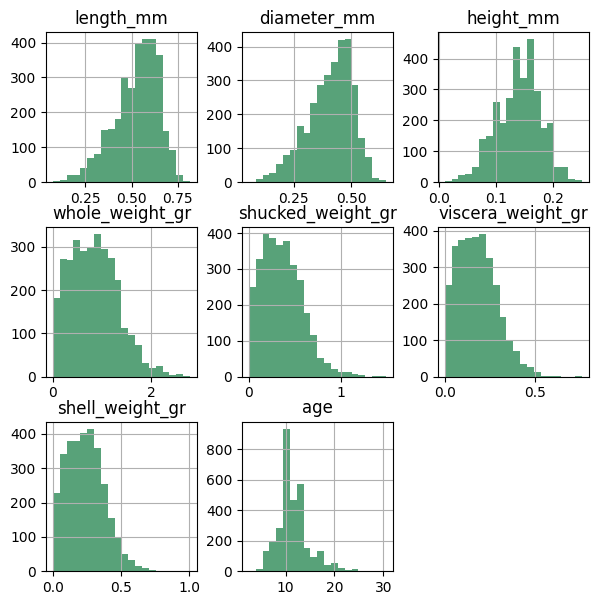

In [10]:
# 2.4 Visualize the histograms for each covariate
df_train.hist(figsize=(7,7), color='seagreen', alpha=0.8, bins=20)
plt.show()

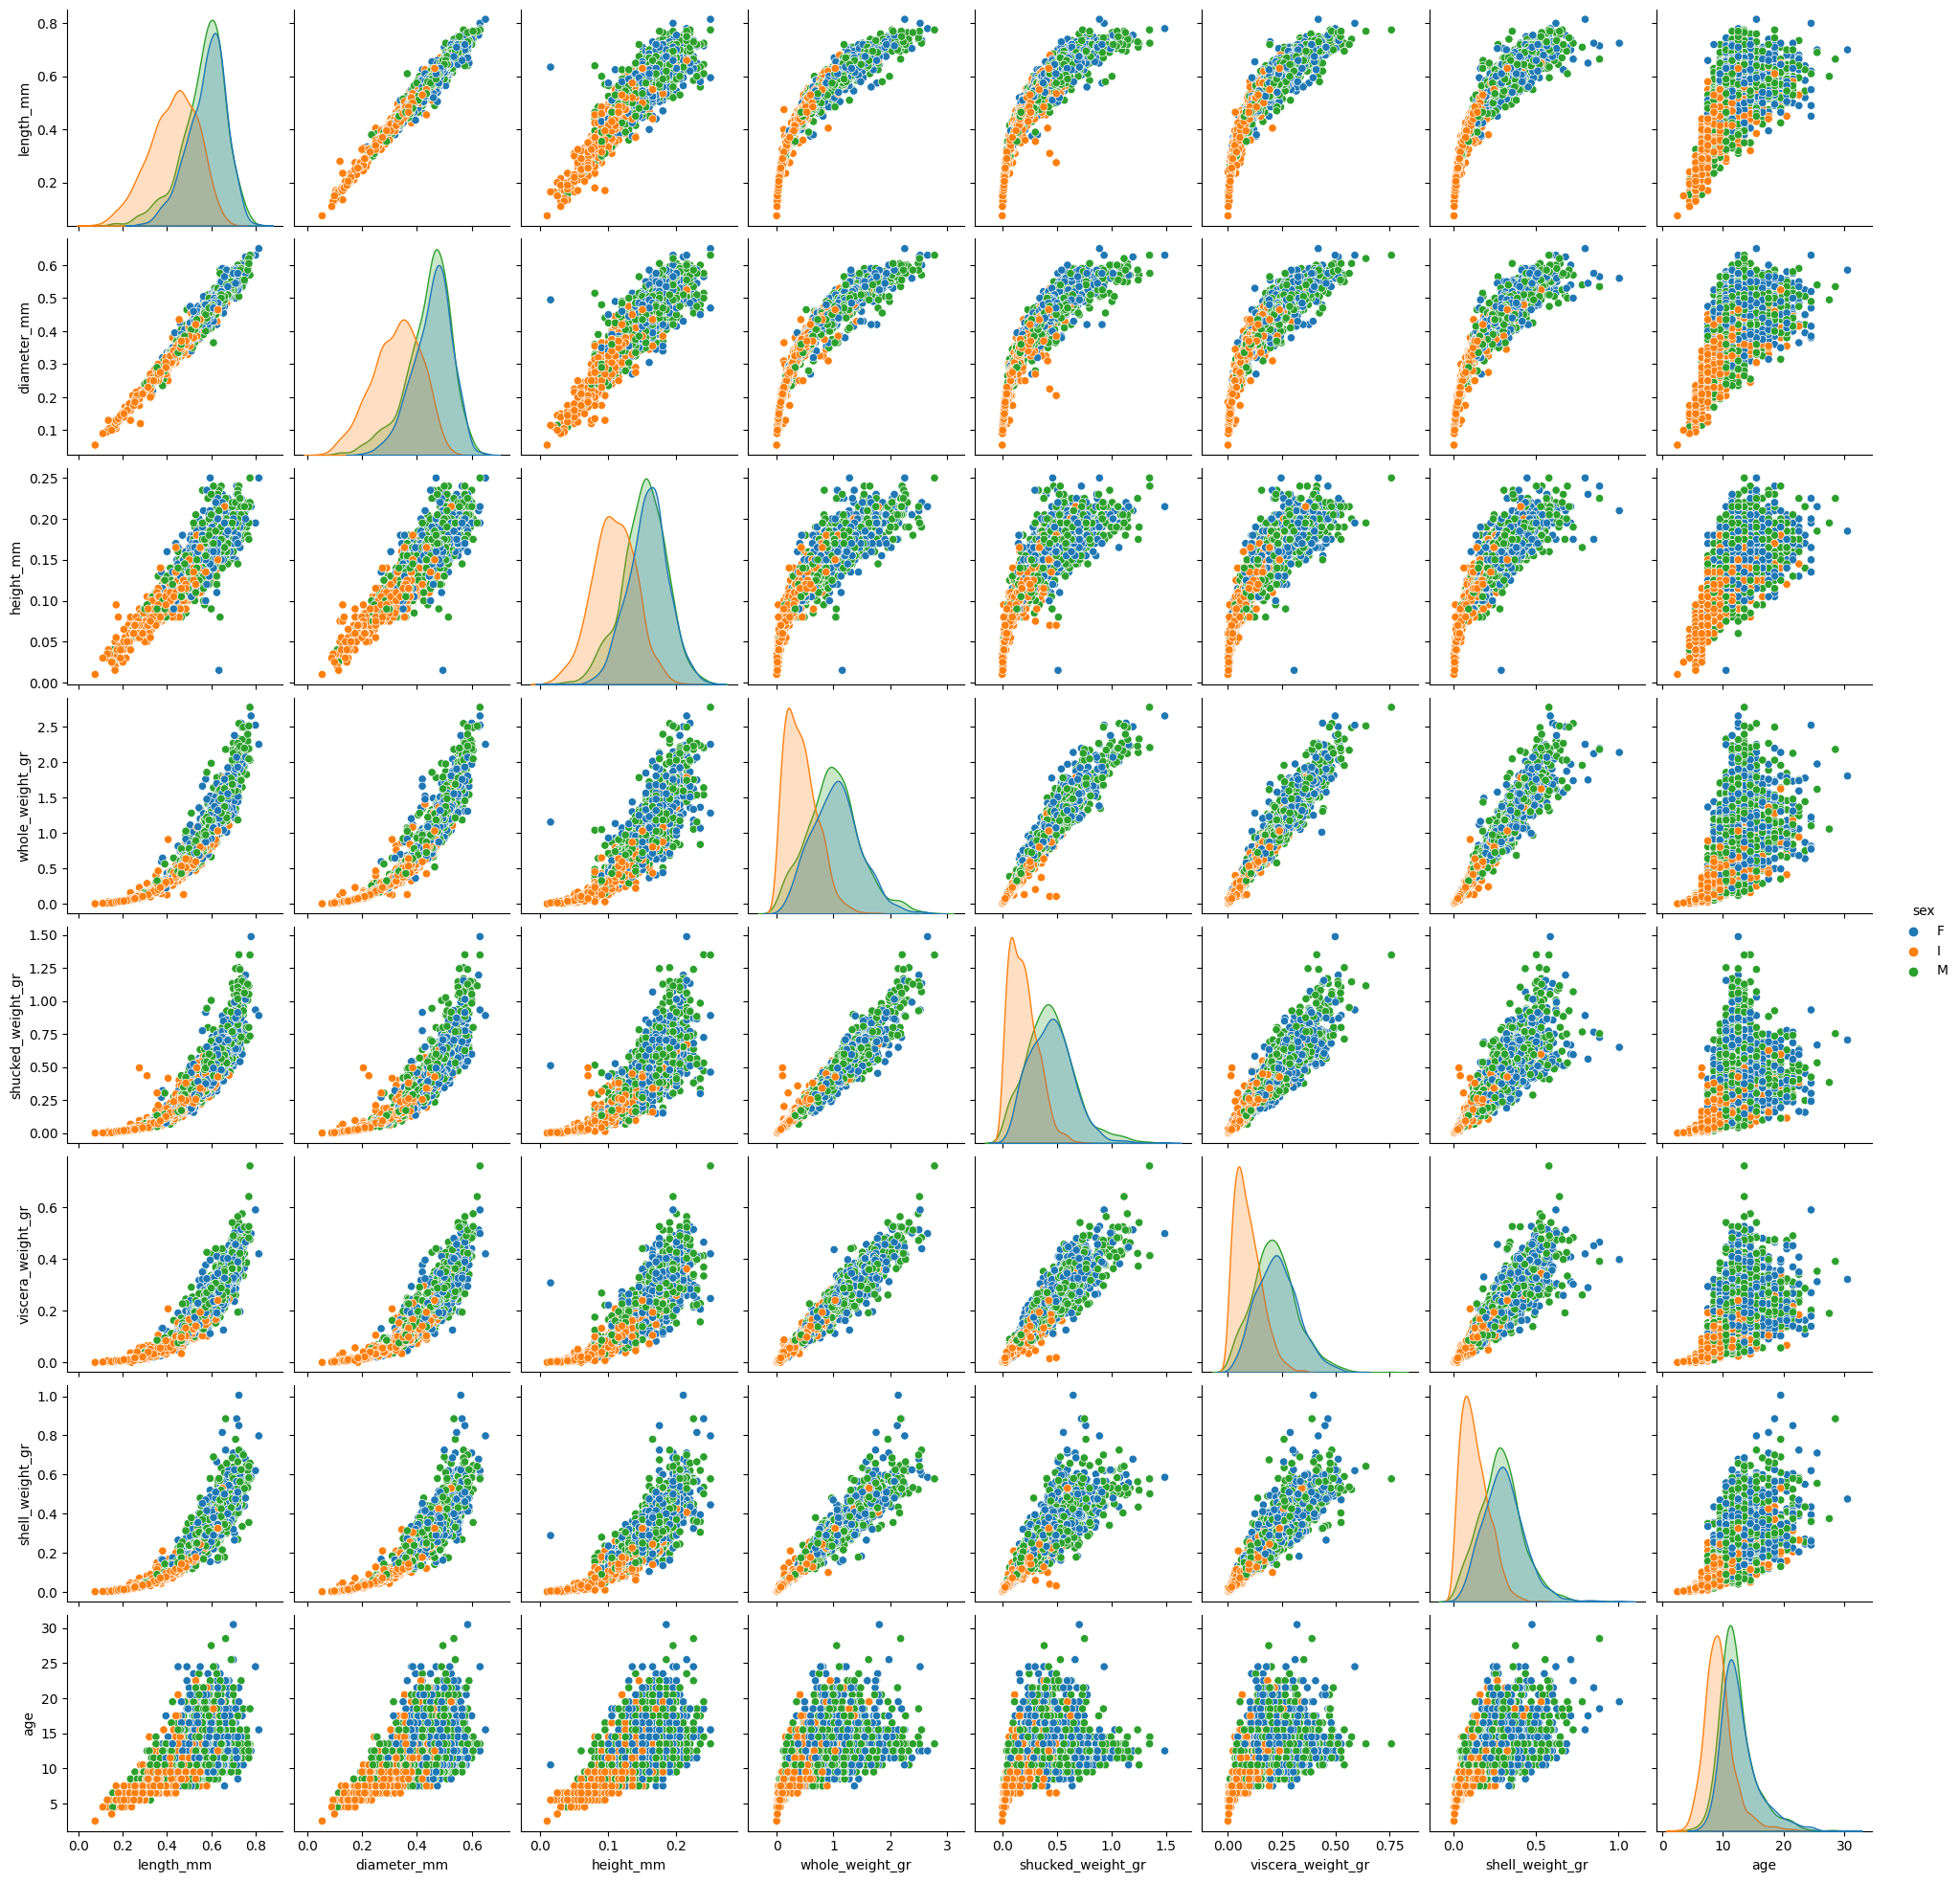

In [11]:
# 2.5 Visualize the bivariate plots
sns.pairplot(data=df_train, hue='sex')
plt.show()

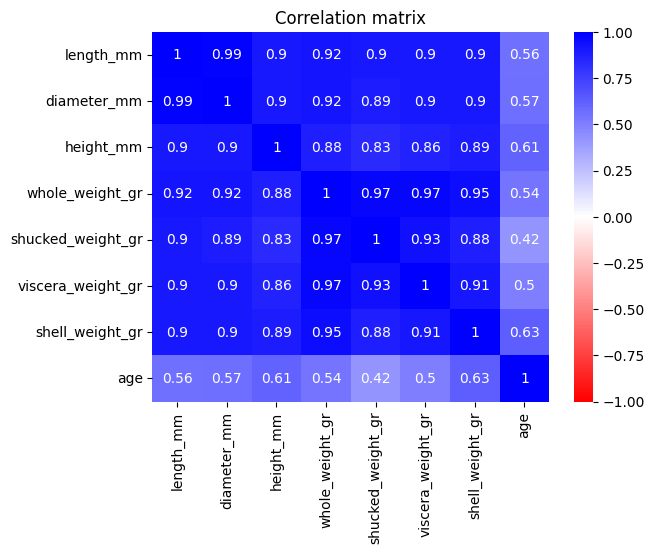

In [12]:
# 2.6 Generate the correlation plot
sns.heatmap(data=df_train.corr().round(2), annot=True, vmax=1, vmin=-1, cmap='bwr_r')
plt.title('Correlation matrix')
plt.show()

In [13]:
# 2.7 Calculate the Variance Inflation Factor for multicollinearity 
X_vif = X_train.drop('sex', axis=1).assign(const=1)
vif = [variance_inflation_factor(X_vif, i) for i in range(len(X_vif.columns))]
df_vif = pd.DataFrame({'name':X_vif.columns,'vif':vif,})
df_vif.style.background_gradient(cmap='Blues')

,name,vif
0,length_mm,41.541670
1,diameter_mm,42.618483
2,height_mm,6.570200
3,whole_weight_gr,109.440436
4,shucked_weight_gr,27.810861
5,viscera_weight_gr,17.375341
6,shell_weight_gr,21.881843
7,const,62.835449


In [ ]:
# 2.X Intermezzo
df_mezzo = df_train.copy()

In [14]:
# 2.8 Create new variables to handle multicollinearity
def modify_dataframe(dfp: pd.DataFrame):
    df = dfp.copy()
    df['ratio_diameter_length'] = df['diameter_mm'] / \
        df['length_mm']
    df['ratio_viscera_meat'] = df['viscera_weight_gr'] / \
        df['shucked_weight_gr']
    df['ratio_diameter_shell'] = df['diameter_mm'] / \
        df['shell_weight_gr']
    df['ratio_shell_weight'] = df['shell_weight_gr'] / \
        df['whole_weight_gr']
    query_string = '(shell_weight_gr < whole_weight_gr) & ' + \
        '(height_mm < 1) & (height_mm > 0) & (diameter_mm < length_mm)'
    df = df.query(query_string)
    df = df.drop(['diameter_mm','shucked_weight_gr','length_mm',\
        'diameter_mm','viscera_weight_gr','shell_weight_gr'], axis=1)
    return df

# df_mod = df_train.copy()
# df_mod['ratio_diameter_length'] = df_mod['diameter_mm'] / \
#     df_mod['length_mm']
# df_mod['ratio_viscera_meat'] = df_mod['viscera_weight_gr'] / \
#     df_mod['shucked_weight_gr']
# df_mod['ratio_diameter_shell'] = df_mod['diameter_mm'] / \
#     df_mod['shell_weight_gr']
# df_mod['ratio_shell_weight'] = df_mod['shell_weight_gr'] / \
#     df_mod['whole_weight_gr']
# query_string = '(shell_weight_gr < whole_weight_gr) & ' + \
#     '(height_mm < 1) & (height_mm > 0) & (diameter_mm < length_mm)'
# df_mod = df_mod.query(query_string)
# df_mod = df_mod.drop(['diameter_mm','shucked_weight_gr',\
#     'length_mm','diameter_mm','viscera_weight_gr','shell_weight_gr'], axis=1)

df_mod = modify_dataframe(df_train)

In [42]:
df_mod.describe().T

,count,mean,std,min,25%,50%,75%,max
height_mm,3129.0,0.139660,0.038446,0.010000,0.115000,0.145000,0.165000,0.250000
whole_weight_gr,3129.0,0.831921,0.488825,0.002000,0.447500,0.807000,1.154000,2.779500
age,3129.0,11.445989,3.249330,2.500000,9.500000,10.500000,12.500000,30.500000
ratio_diameter_length,3129.0,0.775223,0.033505,0.428571,0.755814,0.776119,0.795082,0.962963
ratio_viscera_meat,3129.0,0.517124,0.112630,0.016949,0.442222,0.507317,0.580913,1.323529
ratio_diameter_shell,3129.0,2.507097,2.360807,0.557214,1.454545,1.840909,2.692308,36.666667
ratio_shell_weight,3129.0,0.295214,0.047899,0.109341,0.265625,0.290698,0.319197,0.935361


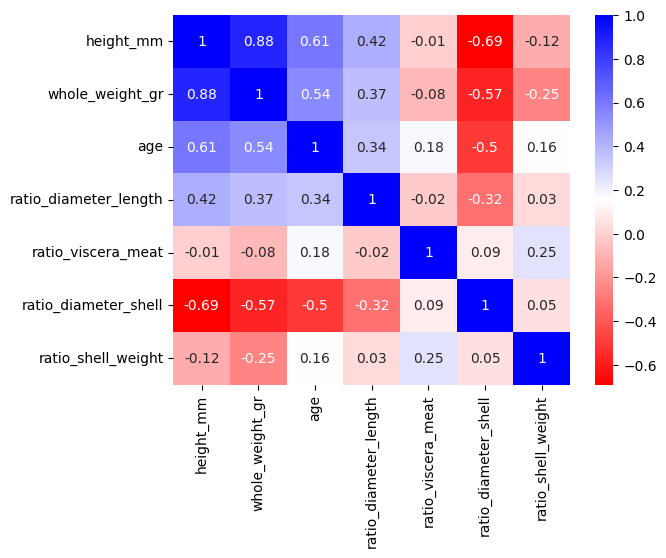

In [15]:
# 2.9 Generate the correlation plot on the new variables
sns.heatmap(data=df_mod.corr().round(2),annot=True, cmap='bwr_r')
plt.show()

In [33]:
# 2.10 Calculate VIF for multicollinearity on the new dataset
X_mod_vif = df_mod.drop('sex', axis=1).assign(const=1)
vif = [variance_inflation_factor(X_mod_vif, i) for i in range(len(X_mod_vif.columns))]
df_vif = pd.DataFrame({'name':X_mod_vif.columns,'vif':vif,})
df_vif.style.background_gradient(cmap='Blues')

,name,vif
0,height_mm,6.603358
1,whole_weight_gr,5.237308
2,age,1.891632
3,ratio_diameter_length,1.239812
4,ratio_viscera_meat,1.147448
5,ratio_diameter_shell,2.010773
6,ratio_shell_weight,1.268540
7,const,659.847161


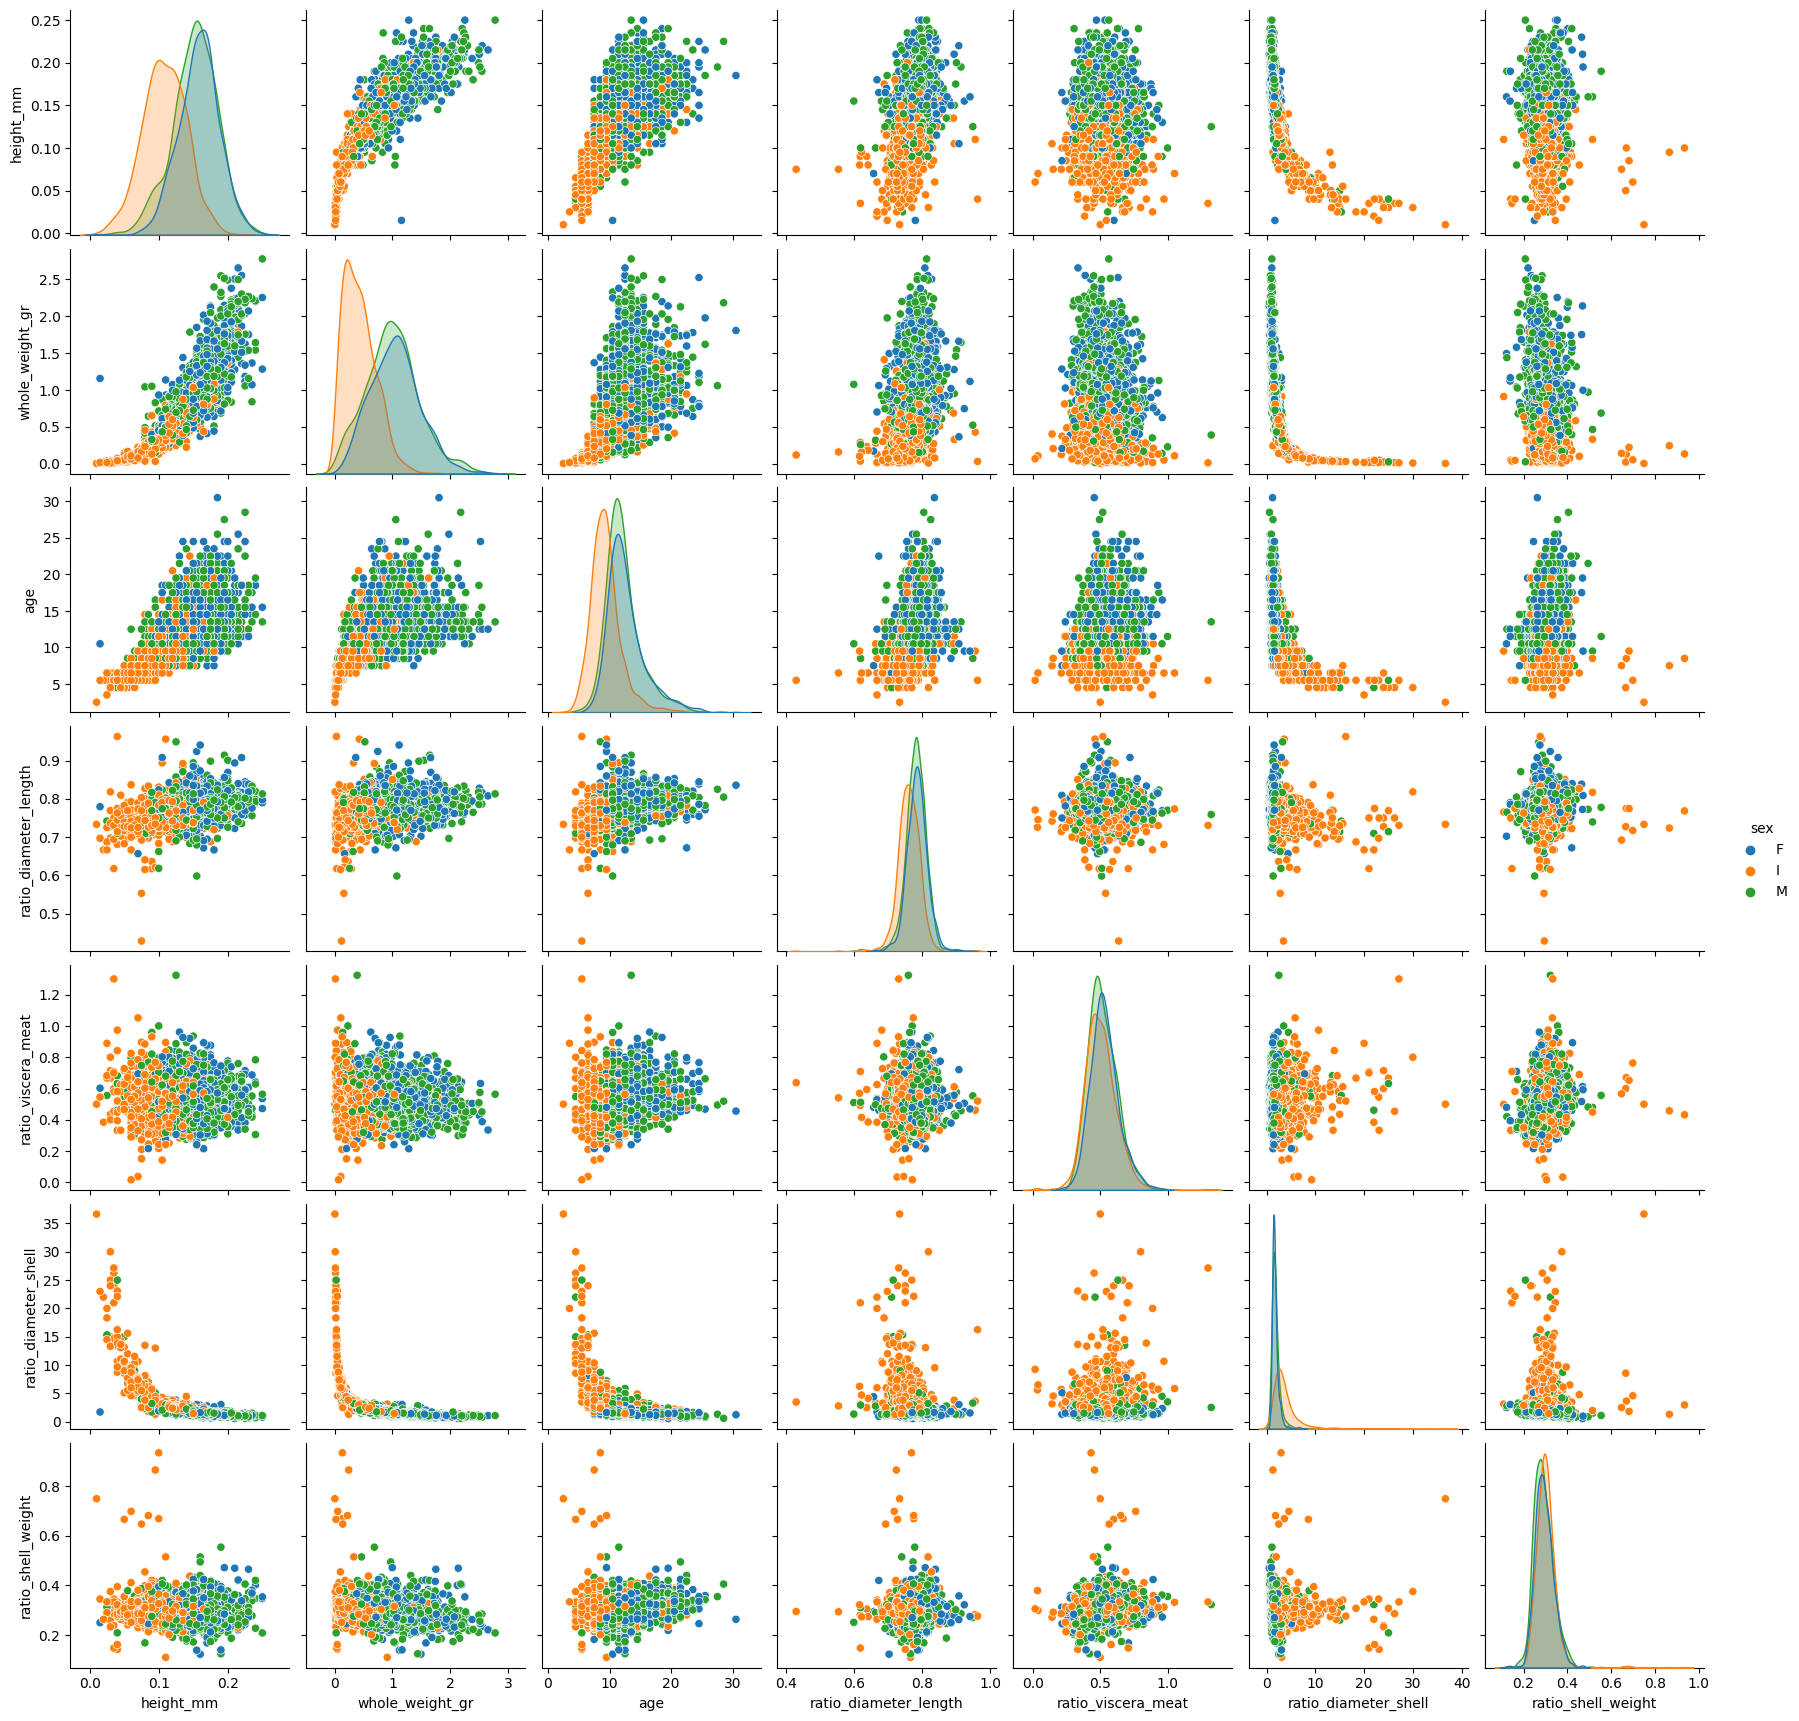

In [17]:
# 2.10 Create a bivariate plot on the new variables
sns.pairplot(data=df_mod, hue='sex')
plt.show()

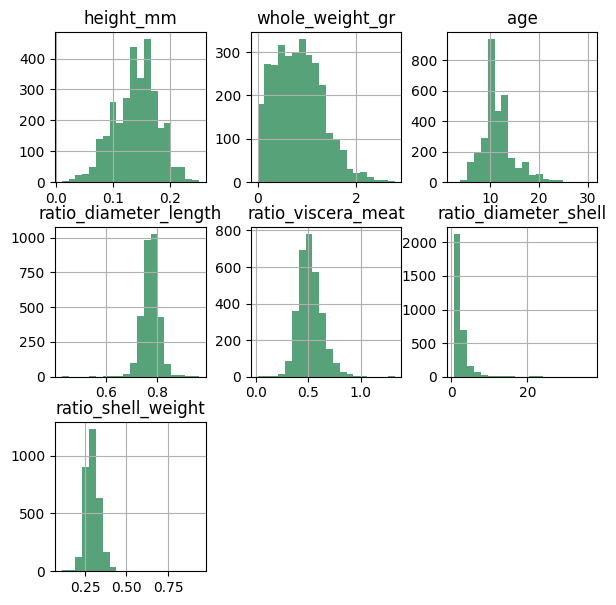

In [18]:
# 2.11 Create a histogram plot for the new variables
df_mod.hist(figsize=(7,7), color='seagreen', alpha=0.8, bins=20)
plt.show()

In [19]:
# 3. Fit a model for prediction and evaluate metrics
# 3.1 Apply the covariate modification to the dataset
X_train_mod = modify_dataframe(X_train)
X_test_mod = modify_dataframe(X_test)

In [44]:
#X_train_mod = X_train_mod.drop(['ratio_diameter_shell'],axis=1)
#X_test_mod = X_test_mod.drop(['ratio_diameter_shell'])
train_bcx_var, lam = boxcox(X_train_mod['ratio_diameter_shell'])
X_train_mod['ratio_diameter_shell'] = train_bcx_var

In [46]:
X_test_mod['ratio_diameter_shell'] = np.power(X_test_mod['ratio_diameter_shell'],lam)

In [40]:
#X_train_mod[] = X_train_mod.drop(['ratio_diameter_shell'],axis=1)
#X_test_mod = X_test_mod.drop(['ratio_diameter_shell'])

(3129,)

In [47]:
# 3.2 Create the pipeline and the hyperparameters for tuning
# Model to apply: Random forest
ppl_rf = Pipeline([
    # Step 1. Scale numeric covariates and encode categorical covariates
    ('cleaning', ColumnTransformer([
        ('num', make_pipeline(MinMaxScaler()), 
        make_column_selector(dtype_exclude='category')),
        ('cat', make_pipeline(OneHotEncoder(drop='first')), 
        make_column_selector(dtype_include='category'))
    ])),
    # Step 2. Apply ML algorithm
    ('rforest', RandomForestRegressor(random_state=123))
])

h_params = [{
    'rforest__min_samples_split':[2,3,4,5,6,7,8],
    'rforest__n_estimators':[1,10,50,75,100,125,250,500,750,1000]
}]

In [48]:
# 3.3 Fit the base model and get the metrics
ppl_rf.fit(X_train_mod, np.squeeze(y_train))
y_hat = ppl_rf.predict(X_test_mod)
print(f'R2 score: {r2_score(y_test, y_hat):.2f} \
    \nRMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.2f}')

R2 score: -0.73     
RMSE: 4.14


In [49]:
# 3.6 Fit a better model by tuning the hyperparameters
cv_rf = GridSearchCV(ppl_rf, h_params)
cv_rf.fit(X_train_mod, np.squeeze(y_train))
y_hat = cv_rf.predict(X_test_mod)
print(f'R2 score: {r2_score(y_test, y_hat):.2f} \
    \nRMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.2f}')

R2 score: -0.83     
RMSE: 4.26


In [23]:
print(cv_rf.best_params_)

{'rforest__min_samples_split': 8, 'rforest__n_estimators': 1000}


In [24]:
# 3.7 Create the pipeline and the hyperparameters for tuning
# Model to apply: XGBoost
ppl_xgb = Pipeline([
    # Step 1. Scale numeric covariates and encode categorical covariates
    ('cleaning', ColumnTransformer([
        ('num', make_pipeline(MinMaxScaler()), 
        make_column_selector(dtype_exclude='category')),
        ('cat', make_pipeline(OneHotEncoder()), 
        make_column_selector(dtype_include='category'))
    ])),
    # Step 2. Apply ML algorithm
    ('xgb', XGBRegressor(random_state=123))
])

h_params = [{
    'xgb__learning_rate':[0.05,0.1,0.15,0.2,0.25,0.3],
    'xgb__max_depth':[3,4,5,6,8,10,12,15],
    'xgb__min_child_weight':[1,3,5,7]
}]

In [25]:
# 3.8 Fit the base model and get the metrics
ppl_xgb.fit(X_train_mod, np.squeeze(y_train))
y_hat = ppl_xgb.predict(X_test_mod)
print(f'R2 score: {r2_score(y_test, y_hat):.2f} \
    \nRMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.2f}')

R2 score: 0.45     
RMSE: 2.33


In [26]:
# 3.9 Fit a better model by tuning the hyperparameters
cv_xgb = GridSearchCV(ppl_xgb, h_params)
cv_xgb.fit(X_train_mod, np.squeeze(y_train))
y_hat = cv_xgb.predict(X_test_mod)
print(f'R2 score: {r2_score(y_test, y_hat):.2f} \
    \nRMSE: {np.sqrt(mean_squared_error(y_test, y_hat)):.2f}')

R2 score: 0.54     
RMSE: 2.14


In [27]:
print(cv_xgb.best_params_)

{'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1}


In [28]:
final_model_xgb = cv_xgb.best_estimator_
y_hat_best = final_model_xgb.predict(X_test_mod)
print(f'R2 score: {r2_score(y_test, y_hat_best):.2f} \
    \nRMSE: {np.sqrt(mean_squared_error(y_test, y_hat_best)):.2f}')

R2 score: 0.54     
RMSE: 2.14


In [29]:
ppl_xgb.named_steps['xgb'].feature_importances_

array([0.03133345, 0.05597726, 0.04703965, 0.06544731, 0.46619967,
       0.09009591, 0.06511129, 0.14099215, 0.03780334], dtype=float32)

In [30]:
features = ppl_xgb.named_steps['xgb'].get_booster().feature_names

In [31]:
ppl_xgb.named_steps['cleaning'].get_feature_names_out()

array(['num__height_mm', 'num__whole_weight_gr',
       'num__ratio_diameter_length', 'num__ratio_viscera_meat',
       'num__ratio_diameter_shell', 'num__ratio_shell_weight',
       'cat__sex_F', 'cat__sex_I', 'cat__sex_M'], dtype=object)

In [32]:
# Further references:
# https://datascience.stackexchange.com/questions/70092/gridsearchcv-using-random-forest-reg-pipeline
# https://towardsdatascience.com/advanced-pipelines-with-scikit-learn-4204bb71019b